In [1]:
import math
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import qmc

from glob import glob
import os

from numba import jit
import dask

import regionmask
import matplotlib.pyplot as plt
# import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

## Dask cluster

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="5GiB",
    walltime="02:30:00",
)

cluster.scale(jobs=30)

In [3]:
# print(cluster.job_script())

In [4]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.159:35315,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preliminaries

In [2]:
#################
## Directories ##
#################
nldas_path = '/storage/group/pches/default/public/NLDAS/'
smap_path = '/storage/group/pches/default/public/SMAP/'
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

# Precalibration (central US test case)

## Setup

In [6]:
# Subset to central US
def _subset_centralUS(ds):
    # Define central US
    centralUS_states = ["Illinois", "Iowa", "Wisconsin", "Minnesota", "North Dakota", "South Dakota", "Nebraska", "Kansas", "Missouri", "Indiana", "Ohio", "Michigan", "Kentucky"]
    # Subset
    centralUS_index = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.map_keys(centralUS_states)
    centralUS_mask = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.mask(ds)
    ds_centralUS = ds.where(centralUS_mask.isin(centralUS_index), drop=True)
    # Return
    return ds_centralUS

In [7]:
#############################################
### Climate forcing & geoophysical inputs ###
#############################################
if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz'):
    # Climate drivers from NLDAS
    year = '20'
    files = glob(f'{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A{year}*.nc')
    ds_nldas_forcing = _subset_centralUS(xr.concat([xr.open_dataset(file) for file in files], dim='time'))

    # Geophysical inputs
    ds_lai = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/LAI_clima_NLDASgrid.nc'))
    ds_awCap = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/NLDAS_NOAH_awCap.nc'))
    ds_wiltingp = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/NLDAS_NOAH_wiltingp.nc'))

    ds_soilfrac = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/soilfrac_NLDASgrid.nc'))

    # Numpy arrays in correct order
    lats = ds_lai.lat.to_numpy()
    doy = ds_nldas_forcing.time.dt.dayofyear.to_numpy() - 1

    tas = np.transpose(ds_nldas_forcing['TMP'].to_numpy() - 273.15, (2,1,0))
    prcp = np.transpose(ds_nldas_forcing['APCP'].to_numpy(), (2,1,0))

    lai = np.transpose(ds_lai['LAI'].to_numpy(), (2,1,0))
    awCap = np.transpose(ds_awCap['awCap'].to_numpy())
    wiltingp = np.transpose(ds_wiltingp['wiltingp'].to_numpy())

    clayfrac = np.transpose(ds_soilfrac['GLDAS_soilfraction_clay'].to_numpy())
    sandfrac = np.transpose(ds_soilfrac['GLDAS_soilfraction_sand'].to_numpy())
    siltfrac = np.transpose(ds_soilfrac['GLDAS_soilfraction_silt'].to_numpy())

    # Store numpy for easy access
    np.savez(f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz',
         tas=tas, prcp=prcp, lai=lai, awCap=awCap, wiltingp=wiltingp, lats=lats, doy=doy, clayfrac=clayfrac, sandfrac=sandfrac, siltfrac=siltfrac)

In [8]:
############################
### Uncertain parameters ###
############################
n_sample = 10_000

if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv'):
    # Define bounds
    awCap_factor_lower, awCap_factor_upper = 0.1, 5.
    wiltingp_factor_lower, wiltingp_factor_upper = 0.1, 5.

    # alpha range ~ 1-10
    alpha_lower, alpha_upper = 0.1 ,10
    # alpha_claycoef_lower, alpha_claycoef_upper = 0.0, 10.
    # alpha_sandcoef_lower, alpha_sandcoef_upper = 0.0, 10.
    # alpha_siltcoef_lower, alpha_siltcoef_upper = 0.0, 10.

    # betaHBV range ~ 1 - 10
    betaHBV_claycoef_lower, betaHBV_claycoef_upper = 0.0, 10.
    betaHBV_sandcoef_lower, betaHBV_sandcoef_upper = 0.0, 10.
    betaHBV_siltcoef_lower, betaHBV_siltcoef_upper = 0.0, 10.

    # GS_start_lower, GS_start_upper = 50, 200
    # GS_length_lower, GS_length_upper = 100, 200
    # rootDepth_oGS_lower, rootDepth_oGS_upper = 100, 1200
    # rootDepth_GS_factor_lower, rootDepth_GS_factor_upper = 2., 10.
    # rootDepth_all_lower, rootDepth_all_upper = 100, 2500

    # LHC sampling
    sampler = qmc.LatinHypercube(d=6)
    sample = sampler.random(n=n_sample)

    # l_bounds = [awCap_factor_lower, wiltingp_factor_lower, alpha_claycoef_lower, alpha_sandcoef_lower, alpha_siltcoef_lower, betaHBV_claycoef_lower, betaHBV_sandcoef_lower, betaHBV_siltcoef_lower]
    # u_bounds = [awCap_factor_upper, wiltingp_factor_upper, alpha_claycoef_upper, alpha_sandcoef_upper, alpha_siltcoef_upper, betaHBV_claycoef_upper, betaHBV_sandcoef_upper, betaHBV_siltcoef_upper]
    
    l_bounds = [awCap_factor_lower, wiltingp_factor_lower, alpha_lower, betaHBV_claycoef_lower, betaHBV_sandcoef_lower, betaHBV_siltcoef_lower]
    u_bounds = [awCap_factor_upper, wiltingp_factor_upper, alpha_upper, betaHBV_claycoef_upper, betaHBV_sandcoef_upper, betaHBV_siltcoef_upper]
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

    # Store as csv
    df = pd.DataFrame(data = sample_scaled,
                      columns = ['awCap_factor', 'wiltingp_factor',
                                 'alpha',
                                 'betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'])
    df['iparam'] = df.index
    df.to_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv', index=False)

In [9]:
########################################################
########## SMAP and NLDAS data for validation ##########
#
# We use volumetric soil moisture anomalies 
# constructed from a weekly climatology 
# (following e.g. Ford & Quiring 2019)
########################################################
# SMAP
if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc'):
    # Read all
    files = glob(f'{smap_path}/processed_nldas_grid/SMAP_L4_SM_gph_all_nldas_*.nc')
    ds_smap = xr.concat([_subset_centralUS(xr.open_dataset(file)['sm_rootzone']) for file in files], dim='time')

    # Use weekly anomalies to validate across different obs
    ds_smap = ds_smap.assign_coords(week=ds_smap.time.dt.strftime("%W"))
    ds_smap_anom = (ds_smap.groupby('week') - ds_smap.groupby("week").mean("time"))
    
    # Merge and store (and change units to kg/m3)
    ds_out = xr.merge([xr.Dataset({'soilMoist':1000*ds_smap}),
                       xr.Dataset({'soilMoist_anom':1000*ds_smap_anom})])
    
    ds_out.attrs['units'] = 'kg/m3'
    ds_out.to_netcdf(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc')
    
    # np.save(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs_anoms_weekly.npy',
    #         np.transpose(1000 * ds_smap_anom['sm_rootzone'].to_numpy(), (2,1,0)))

# NLDAS
nldas_dict = {'VIC':'SOILM0_100cm', 'NOAH':'SOILM', 'MOSAIC':'SOILM'}

for model, var_id in nldas_dict.items():
    if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/{model}_validation.nc'):
        # Read all
        files = glob(f'{nldas_path}/{model}/daily/*.nc')
        ds_nldas = xr.concat([_subset_centralUS(xr.open_dataset(file)[var_id]) for file in files], dim='time')
    
        # Select correct depth
        if model in ['MOSAIC', 'NOAH']:
            ds_nldas = ds_nldas.isel(depth=1)
        else:
            ds_nldas = ds_nldas.isel(depth=0)
    
        # Use weekly anomalies to validate across different obs
        ds_nldas = ds_nldas.assign_coords(week=ds_nldas.time.dt.strftime("%W"))
        ds_nldas_anom = (ds_nldas.groupby('week') - ds_nldas.groupby("week").mean("time"))
        
        # Merge and store
        ds_out = xr.merge([xr.Dataset({'soilMoist':ds_nldas}),
                           xr.Dataset({'soilMoist_anom':ds_nldas_anom})])
        ds_out.attrs['units'] = 'kg/m3'
        ds_out.to_netcdf(f'{project_data_path}/WBM/precalibration/centralUS/{model}_validation.nc')
        
        # np.save(f'{project_data_path}/WBM/precalibration/centralUS/{model}_obs_anoms_weekly.npy',
        #         np.transpose(ds_nldas_anom[var_id].to_numpy(), (2,1,0)))

## Run ensemble

In [10]:
from numba import njit, prange

################
## Model code ##
################

@njit(parallel=False)
def simulate_water_balance_loop(
    Ws_frac_init,
    Wi_init,
    Sp_init,
    P,
    T,
    Ts,
    Tm,
    rootDepth_oGS,
    rootDepth_GS_factor,
    awCap,
    wilting_point,
    GS_start,
    GS_length,
    lai,
    Kc,
    alpha,
    betaHBV,
    phi,
    doy,
):
    """
    Inputs:
     - Ws_frac_init: initial soil moisture content []
     - Wi_init: initial canopy water storage [mm]
     - Sp_init: initial snowpack [mm]
     - Wg_init: initial groundwater [mm]
     - P: daily precipitation timeseries [mm]
     - T: daily mean temperature timeseries [C]
     - Ts: snowfall threshold [C]
     - Tm: snowmelt threshold [C]
     - rootDepth_oGS: root depth outside the growing season [mm]
     - rootDepth_GS: root depth during the growing season [mm]
     - awCap: available water capacity [mm/m]
     - wilting_point: wilting point as fraction of Wcap []
     - GS_start: planting day / start of growing season []
     - GS_length: length of growing season []
     - Kc: crop scalar factor timeseries []
     - lai: leaf area index timeseries []
     - alpha: drying function scale parameter []
     - betaHBV: HBV direct recharge parameter []
     - phi: Latitude [deg]
     - doy: day of year []

    Outputs:
     - Ws: daily soil moisture content timeseries [mm]
     - Ws_frac: daily soil moisture fraction timeseries []
    """
    def calculate_potential_evapotranspiration(T, N, phi):
        """
        Inputs:
         - T: daily mean temperature [C]
         - N: day of year
         - phi: latitude [deg]
        Outputs:
         - daily potential evapotranspiration calculated via the Hamon method [mm]
        Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
        """
        
        # Calculate solar declination (delta)
        delta = -23.44 * math.cos(math.radians((360 / 365) * (N + 10)))
        
        # Calculate fractional day length (Lambda)
        Lambda = (1 / math.pi) * math.acos(
            -math.tan(math.radians(phi)) * math.tan(math.radians(delta))
        )
        
        # Calculate saturation vapor pressure
        if T > 0:
            Psat = 0.61078 * np.exp((17.26939 * T) / (T + 237.3))
        else:
            Psat = 0.61078 * np.exp((21.87456 * T) / (T + 265.5))
        
        # Calculate saturation vapor density (rho_sat)    
        rho_sat = (2.167 * Psat) / (T + 273.15)
        
        # Calculate potential evapotranspiration (PET)
        PET = 330.2 * Lambda * rho_sat
        
        return PET

    ##################################
    # Initialization
    ##################################
    # Simulation dimensions
    nx, ny, nt = T.shape
    
    # Soil moisture capacity
    Wcap = np.empty((nx,ny,366))

    # Soil moisture capacity
    for ix in range(nx):
        for iy in range(ny):
            for t in range(366):
                if (t < GS_start[ix,iy]) or (t > (GS_start[ix,iy] + GS_length[ix,iy])):
                    # outside GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * rootDepth_oGS[ix,iy] / 1000
                else:
                    # during GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * (rootDepth_GS_factor[ix,iy] * rootDepth_oGS[ix,iy]) / 1000

    # Soil moisture [mm]
    Ws = np.empty_like(T)
    Ws[:,:,0] = Ws_frac_init * Wcap[:,:,0]

    # Soil moisture out [mm]
    Ws_out = np.empty_like(T)
    Ws_out[:,:,0] = Ws[:,:,0]

    # Soil moisture fraction
    Ws_frac = np.empty_like(T)
    Ws_frac[:,:,0] = Ws_frac_init
    
    # Canopy water storage
    Wi = np.empty((nx,ny,2))
    Wi[:,:,0] = Wi_init
    
    # Snowpack
    Sp = np.empty((nx,ny,2))
    Sp[:,:,0] = Sp_init

    ######################################
    # Begin simulation
    ######################################
    for ix in range(nx):
        for iy in range(ny):
            for t in range(1, nt):
                # t runs from 1 to n_sim
                # t2 and t2o are 0 or 1 oppositely (used for untracked variables)
                t2 = t % 2
                t2o = int(not(t2))
        
                ################
                # Snowfall
                ################
                # Precipitation is assumed to be entirely snow/rain
                # if temperature is below/above threshold (Ts)
                if T[ix,iy,t] < Ts:
                    Ps = P[ix,iy,t]
                    Pa = 0
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o] + Ps
                else:
                    Pa = P[ix,iy,t]
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o]
        
                ################
                # Snowmelt
                ################
                # Snowmelt is assumed to occur if temperature
                # is above a threshold (Tm), but is limited to
                # the volume of the snowpack
                if T[ix,iy,t] > Tm:
                    Ms = 2.63 + 2.55 * T[ix,iy,t] + 0.0912 * T[ix,iy,t] * Pa
                    if Ms > Sp[ix,iy,t2]:
                        Ms = Sp[ix,iy,t2]
                        Sp[ix,iy,t2] = 0
                    else:
                        Sp[ix,iy,t2] = Sp[ix,iy,t2] - Ms
                else:
                    Ms = 0.0

                #########################
                # Canopy & throughfall
                #########################
                # Maximum canopy storage scales with LAI
                Wi_max = 0.25 * lai[ix,iy,doy[t]]

                # Open water evaporation rate assumed to be PET
                Eow = calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                # Canopy evaporation
                Ec = Eow * ((Wi[ix,iy,t2o] / Wi_max) ** 0.6666667)

                # Throughfall is rainfall minus (canopy storage plus canopy evaporation)
                # Throughfall if zero if all rainfall goes to canopy
                if Wi_max < Pa + Wi[ix,iy,t2o] - Ec:
                    Pt = Pa - Ec - (Wi_max - Wi[ix,iy,t2o])
                else:
                    Pt = 0

                # Update canopy storage
                if Wi[ix,iy,t2o] + (Pa - Pt) - Ec <= Wi_max:
                    if Wi[ix,iy,t2o] + (Pa - Pt) - Ec > 0.0:
                        Wi[ix,iy,t2] = Wi[ix,iy,t2o] + (Pa - Pt) - Ec
                    else:
                        Wi[ix,iy,t2] = 0.0
                else:
                    Wi[ix,iy,t2] = Wi_max

                ########################
                # Evapotranspiration
                ########################
                # Potential ET scales with (annual) crop-specific coefficient
                PET = Kc[ix,iy,doy[t]] * calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                
                # Calculate actual evapotranspiration
                # Actual ET is limited by water availability (throughfall + snowmelt)
                # otherwise the difference is scaled by drying function
                if (Pt + Ms) >= PET:
                    AET = PET
                else:
                    g = (1 - np.exp(-alpha[ix,iy] * Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]])) / (1 - np.exp(-alpha[ix,iy]))
                    AET =  g * (PET - Pt - Ms)

                ################
                # Runoff
                ################
                # HBV direct groundwater recharge (can also be thought of as runoff)
                # scales nonlinearly with saturation in the active zone
                # Direct groundwater recharge (HBV)
                Id = (Pt + Ms) * (Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]]) ** betaHBV[ix,iy]
                
                ################
                # Soil moisture
                ################
                # Soil surplus is the leftover water after saturating soils
                # It gets partitioned to more runoff and groundwater recharge
                if Wcap[ix,iy,doy[t]] < Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET:
                    S = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - Wcap[ix,iy,doy[t]]
                else:
                    S = 0

                # Update soil moisture
                Ws[ix,iy,t] = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - S

                # Soil moisture must be positive
                if Ws[ix,iy,t] < 0:
                    Ws[ix,iy,t] = 0.0

                # Wilting point in mm
                wilting_point_mm = wilting_point[ix,iy] * Wcap[ix,iy,doy[t]]
                
                # Soil wetness
                # Ws_frac[ix,iy,t] = (Ws[ix,iy,t] + wilting_point_mm) / (Wcap[ix,iy,doy[t]] + wilting_point_mm)

                # Soil moisture out (+ wilting point)
                Ws_out[ix,iy,t] = Ws[ix,iy,t] + wilting_point_mm
    
    # Return
    return Ws_out #, Ws, Wcap, Ms_out, Sp, Pa_out, Ps_out #Wg, AET_out, PET_out, g_out, Sp, Pt_out, Wcap

In [11]:
def run_WBMpy(forcing,
              alpha,
              betaHBV_claycoef,
              betaHBV_sandcoef,
              betaHBV_siltcoef,
              Ts,
              Tm,
              Kc,
              awCap_factor,
              wiltingp_factor,
              Ws_frac_init,
              Wi_init,
              Sp_init,
              GS_start,
              GS_length,
              rootDepth_oGS,
              rootDepth_GS_factor,
              iparam,
              store_path,
              simulate_water_balance_loop):
    
    # Read and extract inputs
    npz = np.load(forcing)
    tas_in = npz['tas']
    prcp_in = npz['prcp']
    lai_in = npz['lai']
    awCap = npz['awCap']
    wiltingp = npz['wiltingp']
    lats_in = npz['lats']
    doy_in = npz['doy']
    clayfrac = npz['clayfrac']
    sandfrac = npz['sandfrac']
    siltfrac = npz['siltfrac']
    
    # Setup arrays
    nlon, nlat = awCap.shape
    
    grid = np.ones((nlon, nlat))

    # alpha_coef = 1. + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    # alpha_coef = 1. + alpha_claycoef
    alpha_in =  alpha * grid

    betaHBV_coef = 1. + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac)
    betaHBV_in = betaHBV_coef * grid
    
    Kc_in = Kc * np.ones(lai_in.shape)
    awCap_in = awCap_factor * awCap
    wiltingp_in = wiltingp_factor * wiltingp
    Ws_frac_init_in = Ws_frac_init * grid
    Wi_init_in = Wi_init * grid
    Sp_init_in = Sp_init * grid
    GS_start_in = GS_start * grid
    GS_length_in = GS_length * grid
    rootDepth_oGS_in = rootDepth_oGS * grid
    rootDepth_GS_factor_in = rootDepth_GS_factor * grid

    # Run it
    out = simulate_water_balance_loop(
        Ws_frac_init = Ws_frac_init_in,
        Wi_init = Wi_init_in,
        Sp_init = Sp_init_in,
        P = prcp_in,
        T = tas_in,
        Ts = Ts,
        Tm = Tm,
        rootDepth_oGS = rootDepth_oGS_in,
        rootDepth_GS_factor = rootDepth_GS_factor_in,
        awCap = awCap_in,
        wilting_point = wiltingp_in,
        GS_start = GS_start_in,
        GS_length = GS_length_in,
        lai = lai_in,
        Kc = Kc_in,
        alpha = alpha_in,
        betaHBV = betaHBV_in,
        phi = lats_in,
        doy = doy_in
    )

    # Store
    np.save(f'{store_path}/{str(iparam)}_Ws.npy', out)

In [12]:
# Run ensemble
df_param = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv')

# Constants
Ts = -1.             # Snowfall threshold
Tm = 1.              # Snowmelt threshold
Ws_frac_init = 0.5   # Initial soil moisture
Wi_init = 0.         # Initial canopy water storage
Sp_init = 0.         # Initial snowpack

# Neglect influence of growing season for now
GS_start = 120
GS_length = 182
rootDepth_oGS = 1000
rootDepth_GS_factor = 1
Kc = 1

# Dask delayed
delayed = []
for iparam in range(10_000):
    # Check if done
    if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}_Ws.npy'):
        # Get uncertain parameters
        awCap_factor = df_param[df_param.iparam == iparam]['awCap_factor'].values[0]
        wiltingp_factor = df_param[df_param.iparam == iparam]['wiltingp_factor'].values[0]
        
        # alpha_claycoef = df_param[df_param.iparam == iparam]['alpha_claycoef'].values[0]
        # alpha_sandcoef = df_param[df_param.iparam == iparam]['alpha_sandcoef'].values[0]
        # alpha_siltcoef = df_param[df_param.iparam == iparam]['alpha_siltcoef'].values[0]

        alpha = df_param[df_param.iparam == iparam]['alpha'].values[0]    
        
        betaHBV_claycoef = df_param[df_param.iparam == iparam]['betaHBV_claycoef'].values[0]
        betaHBV_sandcoef = df_param[df_param.iparam == iparam]['betaHBV_sandcoef'].values[0]
        betaHBV_siltcoef = df_param[df_param.iparam == iparam]['betaHBV_siltcoef'].values[0]

        # Delayed calculation
        tmp = dask.delayed(run_WBMpy)(
            forcing = f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz',
            # alpha_claycoef = alpha_claycoef,
            # alpha_sandcoef = alpha_sandcoef,
            # alpha_siltcoef = alpha_siltcoef,
            alpha = alpha,
            betaHBV_claycoef = betaHBV_claycoef,
            betaHBV_sandcoef = betaHBV_sandcoef,
            betaHBV_siltcoef = betaHBV_siltcoef,
            Ts = Ts,
            Tm = Tm,
            Kc = Kc,
            awCap_factor = awCap_factor,
            wiltingp_factor = wiltingp_factor,
            Ws_frac_init = Ws_frac_init,
            Wi_init = Wi_init,
            Sp_init = Sp_init,
            GS_start = GS_start,
            GS_length = GS_length,
            rootDepth_oGS = rootDepth_oGS,
            rootDepth_GS_factor = rootDepth_GS_factor,
            iparam = iparam,
            store_path = f'{project_data_path}/WBM/precalibration/centralUS/out',
            simulate_water_balance_loop = simulate_water_balance_loop
        )

        delayed.append(tmp)

In [13]:
len(delayed)

0

In [14]:
%%time
# Compute
results = dask.compute(*delayed)

CPU times: user 1min 49s, sys: 8.75 s, total: 1min 57s
Wall time: 42min 39s


## Analysis

### Calculate metrics

In [3]:
# Get Pearson correlation and RMSE
def calculate_error_metrics(project_data_path, iparam):
    try:
        # Read simulation output
        sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}_Ws.npy')

        # Read SMAP for coords
        smap_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc').drop(['soilMoist_anom', 'week'])

        # Construct xr 
        ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=smap_obs.lon,
                lat=smap_obs.lat,
                time=smap_obs.time)
        )

        # Get anomaly from weekly climatology
        ds_sim['soilMoist_clima'] = ds_sim['soilMoist'].groupby(ds_sim.time.dt.isocalendar().week).mean("time")
        ds_sim['soilMoist_anom'] = (ds_sim['soilMoist'].groupby(ds_sim.time.dt.isocalendar().week) - ds_sim['soilMoist_clima'])
        
        smap_obs['soilMoist_clima'] = smap_obs['soilMoist'].groupby(smap_obs.time.dt.isocalendar().week).mean("time")
        smap_obs['soilMoist_anom'] = (smap_obs['soilMoist'].groupby(smap_obs.time.dt.isocalendar().week) - smap_obs['soilMoist_clima'])
        
        # Read other observations
        def calculate_weekly_clima(ds):
            ds_tmp = ds.copy().drop(['soilMoist_anom', 'week'])
            ds_tmp['soilMoist_clima'] = ds_tmp['soilMoist'].groupby(ds_tmp.time.dt.isocalendar().week).mean("time")
            ds_tmp['soilMoist_anom'] = (ds_tmp['soilMoist'].groupby(ds_tmp.time.dt.isocalendar().week) - ds_tmp['soilMoist_clima'])
            return ds_tmp
            
        noah_obs = calculate_weekly_clima(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/NOAH_validation.nc'))
        vic_obs = calculate_weekly_clima(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/VIC_validation.nc'))
        mosaic_obs = calculate_weekly_clima(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/MOSAIC_validation.nc'))

        # Person correlation
        # smap_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), smap_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')
        # vic_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), vic_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')
        # mosaic_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), mosaic_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')
        # noah_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), noah_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')

        # smap_corr = xr.corr(ds_sim['soilMoist_clima'], smap_obs['soilMoist_clima'], dim='time')
        # vic_corr = xr.corr(ds_sim['soilMoist_clima'], vic_obs['soilMoist_clima'], dim='time')
        # mosaic_corr = xr.corr(ds_sim['soilMoist_clima'], mosaic_obs['soilMoist_clima'], dim='time')
        # noah_corr = xr.corr(ds_sim['soilMoist_clima'], noah_obs['soilMoist_clima'], dim='time')
        
        smap_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), smap_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')
        vic_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), vic_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')
        mosaic_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), mosaic_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')
        noah_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), noah_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')

        # RMSE
        def _calculate_rmse(ds1, ds2):
            return np.sqrt(((ds1 - ds2)**2).mean(dim='week'))

        # smap_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), smap_obs['soilMoist'].isel(time=slice(100,3000)))
        # vic_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), vic_obs['soilMoist'].isel(time=slice(100,3000)))
        # mosaic_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), mosaic_obs['soilMoist'].isel(time=slice(100,3000)))
        # noah_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), noah_obs['soilMoist'].isel(time=slice(100,3000)))

        smap_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], smap_obs['soilMoist_clima'])
        vic_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], vic_obs['soilMoist_clima'])
        mosaic_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], mosaic_obs['soilMoist_clima'])
        noah_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], noah_obs['soilMoist_clima'])
        
        # smap_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), smap_obs['soilMoist_anom'].isel(time=slice(100,3000)))
        # vic_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), vic_obs['soilMoist_anom'].isel(time=slice(100,3000)))
        # mosaic_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), mosaic_obs['soilMoist_anom'].isel(time=slice(100,3000)))
        # noah_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), noah_obs['soilMoist_anom'].isel(time=slice(100,3000)))

        # Merge all
        ds_out = xr.Dataset({
            # 'smap_pearsonr': smap_corr,
            'smap_pearsonr_anom': smap_corr_anom,
            # 'vic_pearsonr': vic_corr,
            'vic_pearsonr_anom': vic_corr_anom,
            # 'noah_pearsonr': noah_corr,
            'noah_pearsonr_anom': noah_corr_anom,
            # 'mosaic_pearsonr': mosaic_corr,
            'mosaic_pearsonr_anom': mosaic_corr_anom,
            'smap_rmse_clima': smap_rmse,
            # 'smap_rmse_anom': smap_rmse_anom,
            'vic_rmse_clima': vic_rmse,
            # 'vic_rmse_anom': vic_rmse_anom,
            'noah_rmse_clima': noah_rmse,
            # 'noah_rmse_anom': noah_rmse_anom,
            'mosaic_rmse_clima': mosaic_rmse,
            # 'mosaic_rmse_anom': mosaic_rmse_anom,
        })
        
        # Return spatial average
        return ds_out.mean(dim=['lat','lon']).assign_coords(iparam=[iparam]).to_dataframe()
            
    except Exception as e:
         with open(f'/storage/work/dcl5300/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs/{str(iparam)}.txt', 'w') as f:
            f.write(str(e))
            return None

In [7]:
# Delayed
delayed = []

for iparam in range(10_000):
    tmp = dask.delayed(calculate_error_metrics)(project_data_path = project_data_path,
                                                iparam = iparam)
    delayed.append(tmp)

In [ ]:
%%time
# Compute
out = dask.compute(*delayed)

# Store
pd.concat(out).to_csv(f'{project_data_path}/WBM/precalibration/centralUS/results_2step.csv')

### Plots

In [4]:
# Read
# df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/results.csv')
df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/results_NoAnom.csv')
df_params = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv')

In [5]:
# Read sim
def read_sim(iparam):
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}_Ws.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125),
                lat=np.arange(36.063, 49.313001, 0.125),
                time=pd.date_range(start='01/01/2016', end='12/31/2022')))
    
    # Return
    return ds_sim

In [6]:
def plot_map(obs, n_cutoff, axs):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs.isel(time=slice(100,3000)).soilMoist
    
    # Get top N_cutoff params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    ds_best = read_sim(iparam_best).isel(time=slice(100,3000))
    ds_best = ds_best.where(ds_best.time.isin(obs_tmp.time), drop=True).soilMoist
    
    # For coverage
    maxs = np.zeros(ds_best.shape)
    mins = np.ones(ds_best.shape) * 1e6
    
    # Get ensemble bounds
    for iparam in iparam_top_n:
        # Read
        ds_tmp = read_sim(iparam).isel(time=slice(100,3000))
        # Align datetimes
        ds_tmp = ds_tmp.where(ds_tmp.time.isin(ds_obs.time), drop=True).soilMoist
        # Iterativalely calculate bounds
        maxs = np.max([maxs, ds_tmp.to_numpy()], axis=0)
        mins = np.min([mins, ds_tmp.to_numpy()], axis=0)

    # Align obs datetimes
    obs_tmp = obs_tmp.where(obs_tmp.time.isin(ds_tmp.time), drop=True)
    
    # Get coverage
    coverage = 100 * (1 - ((((obs_tmp.to_numpy() > maxs).sum(axis=0) + (obs_tmp.to_numpy() < mins).sum(axis=0))) / obs_tmp.shape[0]))

    # Construct ds for coverage
    ds_coverage = xr.Dataset(
        data_vars=dict(coverage=(["lat", "lon"], np.ma.masked_array(coverage, np.isnan(maxs[0,:,:])))),
        coords=dict(
            lon=np.arange(-103.938, -80.5629999, 0.125),
            lat=np.arange(36.063, 49.313001, 0.125)))

    # Plot coverage
    p = ds_coverage.coverage.plot(ax=axs[1], vmin=0, vmax=100, cmap = "Greens", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Coverage (%)",
                 ax=axs[1],
                 pad=0.04)

    # Plot best RMSE
    ds_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean(dim='time'))
    p = ds_rmse.plot(ax=axs[0], vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Best RMSE [mm]",
                 ax=axs[0],
                 pad=0.04)

    # Tidy
    for ax in axs:
        ax.coastlines()
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

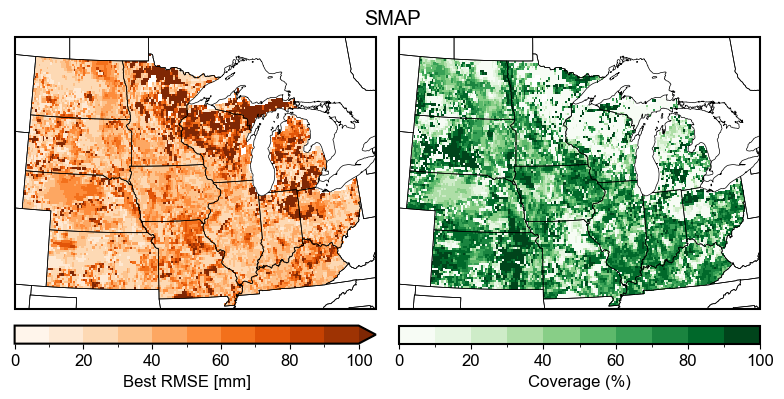

In [16]:
# SMAP
obs = 'smap'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

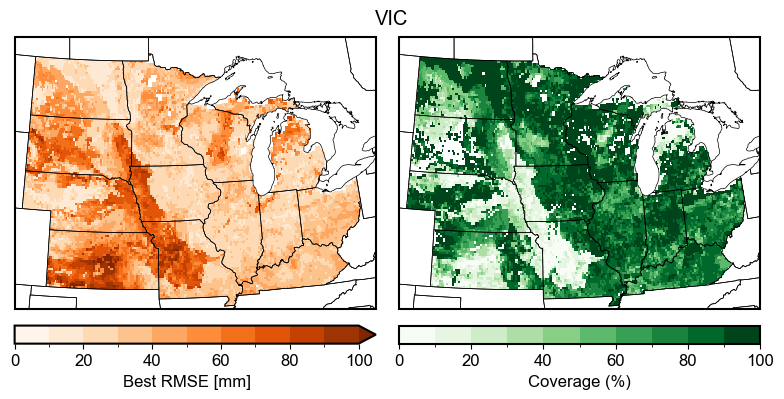

In [17]:
# VIC
obs = 'vic'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

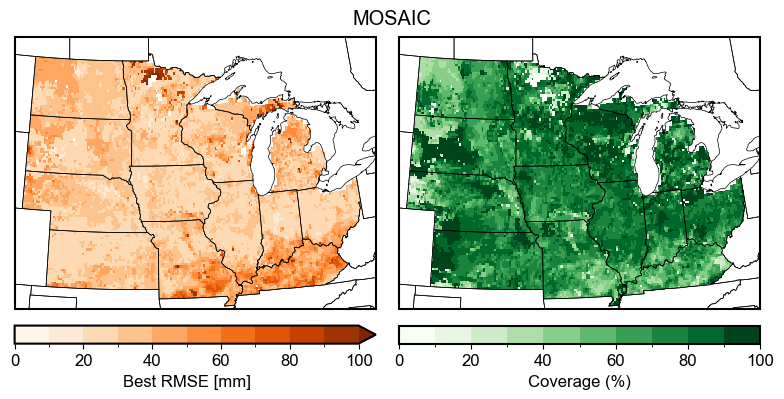

In [18]:
# MOSAIC
obs = 'mosaic'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

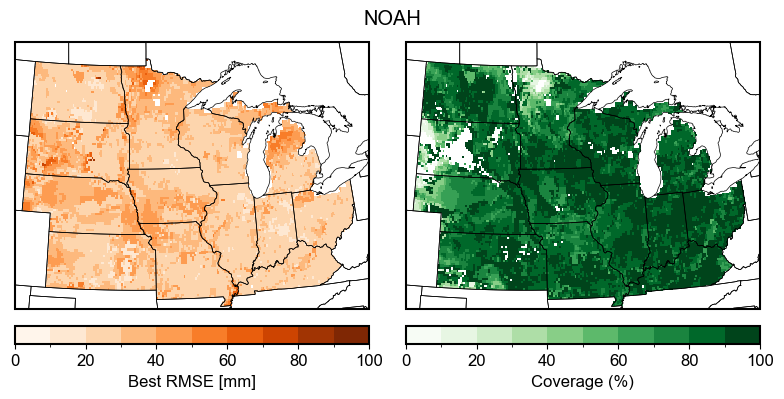

In [19]:
# NOAH
obs = 'noah'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

In [36]:
def plot_ts(obs, lat, lon, n_cutoff, ylabel, xlabel, ax):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs.isel(time=slice(200,3000)).sel(lat=lat, lon=lon, method='nearest')
    
    # Get top N_cutoff params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    ds_best = read_sim(iparam_best).isel(time=slice(100,3000)).sel(lat=lat, lon=lon, method='nearest')
    ds_best = ds_best.where(ds_best.time.isin(obs_tmp.time), drop=True).soilMoist
    
    # For surprise index
    sim_all = []
    
    # Plot simulations
    for iparam in iparam_top_n:
        # Read
        ds_tmp = read_sim(iparam).isel(time=slice(200,3000)).sel(lat=lat, lon=lon, method='nearest')
        # Align datetimes
        ds_tmp = ds_tmp.where(ds_tmp.time.isin(obs_tmp.time), drop=True).soilMoist
        # Plot
        ds_tmp.plot(ax=ax, color='silver', alpha=0.8)
        # Append for surpise index
        sim_all.append(ds_tmp.to_numpy())
    
    # Plot obs
    obs_tmp = obs_tmp.where(obs_tmp.time.isin(ds_tmp.time), drop=True).soilMoist
    obs_tmp.plot(ax=ax, color='darkred', zorder=3)

    # Plot best
    ds_best.plot(ax=ax, color='dimgrey', zorder=2)
    best_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean())
    
    # Get surprise index
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    
    coverage = 1 - ((((obs_tmp.to_numpy() > maxs).sum() + (obs_tmp.to_numpy() < mins).sum())) / len(obs_tmp))
    
    # Print info
    text_str = '\n'.join((f"Best RMSE: {best_rmse:.2f}mm", \
                         f"Coverage: {100*coverage:.2f}%"))
    
    ax.text(x=0.65, y=0.16,
            s = text_str,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)

    ax.grid()
    ax.set_title(obs.upper())
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

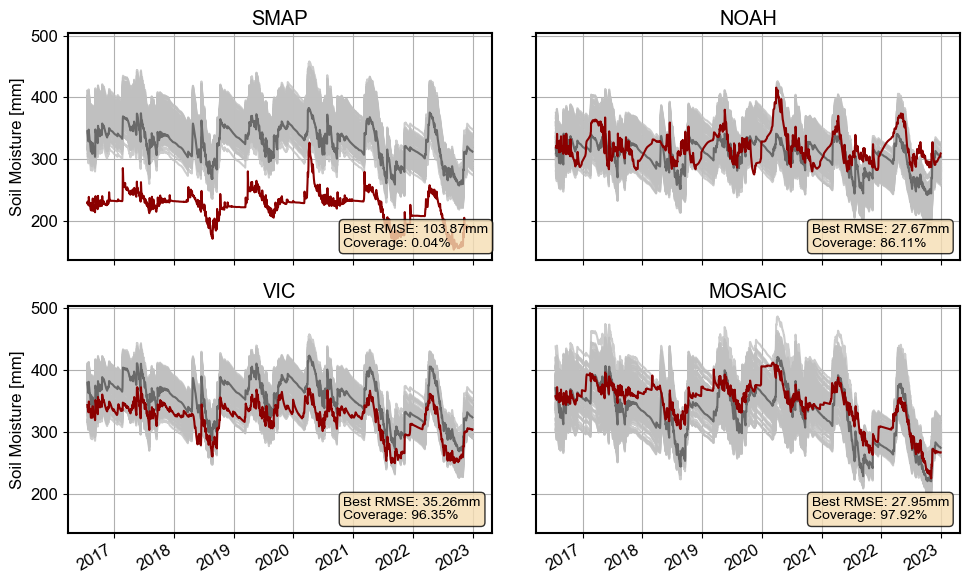

In [37]:
# Main plot
lat, lon = 46,-90.8
n_cutoff = 100

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts("smap", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[0,0])
plot_ts("noah", lat, lon, n_cutoff, "", "", axs[0,1])
plot_ts("vic", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[1,0])
plot_ts("mosaic", lat, lon, n_cutoff, "", "", axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

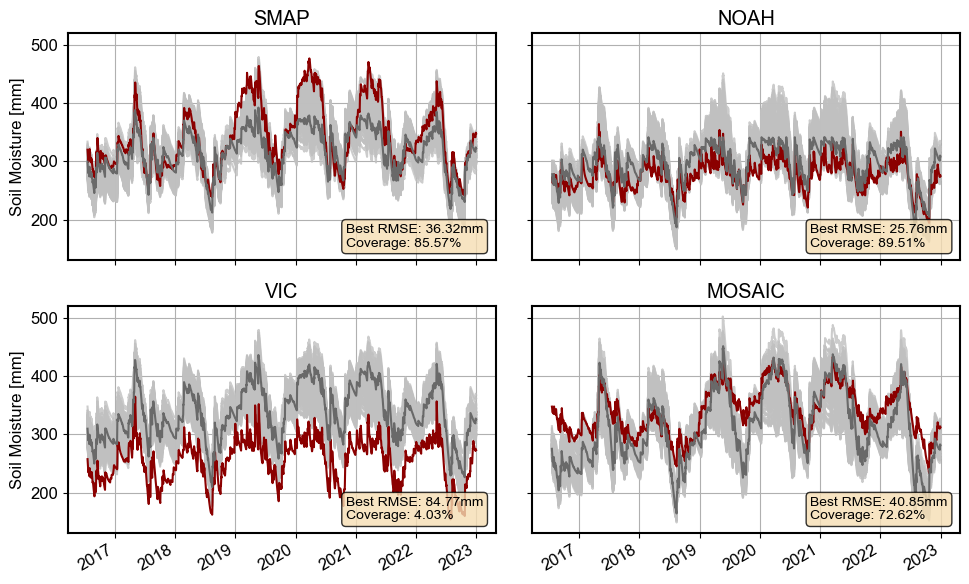

In [32]:
# Main plot
lat, lon = 37.8,-93.5
n_cutoff = 100

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts("smap", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[0,0])
plot_ts("noah", lat, lon, n_cutoff, "", "", axs[0,1])
plot_ts("vic", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[1,0])
plot_ts("mosaic", lat, lon, n_cutoff, "", "", axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

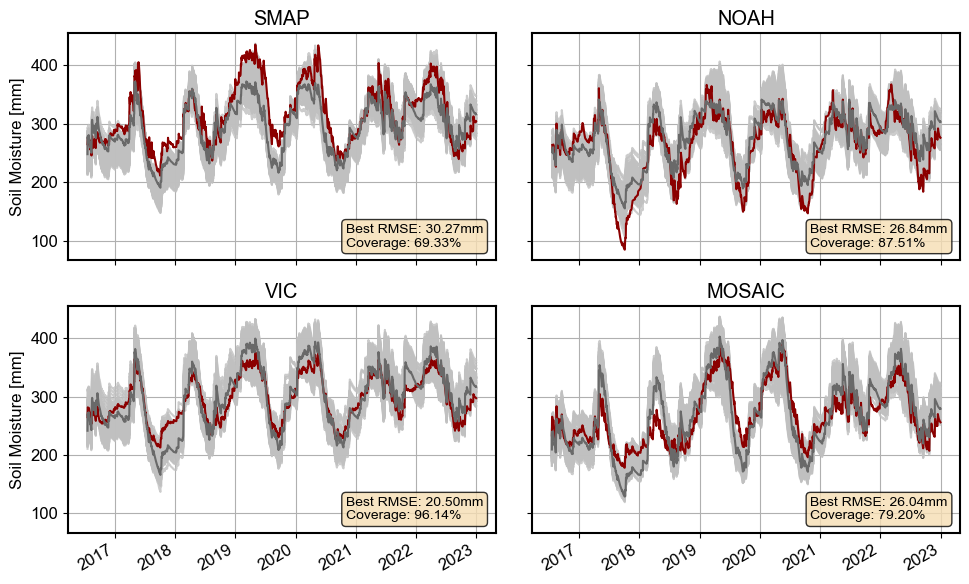

In [33]:
# Main plot
lat, lon = 40,-90
n_cutoff = 100

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts("smap", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[0,0])
plot_ts("noah", lat, lon, n_cutoff, "", "", axs[0,1])
plot_ts("vic", lat, lon, n_cutoff, "Soil Moisture [mm]", "", axs[1,0])
plot_ts("mosaic", lat, lon, n_cutoff, "", "", axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

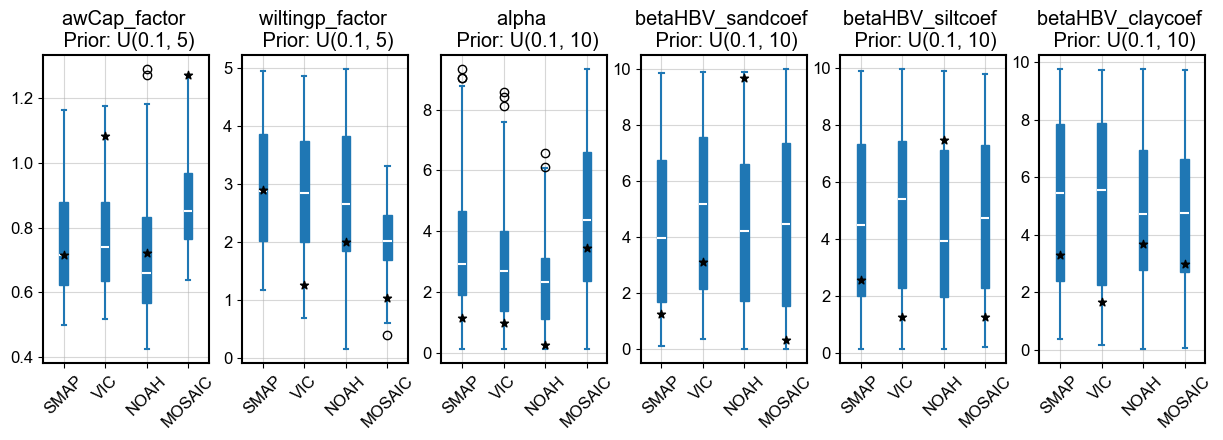

In [85]:
# Do the parameters match?
n_cutoff = 100

params = ['awCap_factor', 'wiltingp_factor', 'alpha', 'betaHBV_sandcoef', 'betaHBV_siltcoef', 'betaHBV_claycoef']
priors = ['U(0.1, 5)', 'U(0.1, 5)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)']
obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['C1', 'C2', 'C3', 'C4']
obs_colors = ['C0', 'C0', 'C0', 'C0']

fig, axs = plt.subplots(1,len(params), figsize=(15,4))

for ido, obs in enumerate(obs_all):
    # Get top params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        # Plot
        data = df_params.iloc[iparam_top_n][param]
        bplot = axs[idx].boxplot(x=data,
                                 vert=True,
                                 positions=[ido],
                                 widths=0.2,
                                 boxprops=dict(color=obs_colors[ido]),
                                 whiskerprops=dict(color=obs_colors[ido], lw=1.5),
                                 medianprops=dict(color='white', lw=1.5),
                                 capprops=dict(color=obs_colors[ido], lw=1.5),
                                 patch_artist=True)
        for patch in bplot['boxes']:
            patch.set_facecolor(obs_colors[ido])
        # Best
        axs[idx].scatter(x = [ido],
                         y = data[iparam_best],
                         marker = '*', color='black', zorder=100)


for idx, ax in enumerate(axs):
    ax.set_title(f'{params[idx]} \n Prior: {priors[idx]}')
    ax.set_xticks(ticks=[0,1,2,3],
                  labels=[obs.upper() for obs in obs_all], rotation=45)
    ax.grid(alpha=0.5)

plt.show()

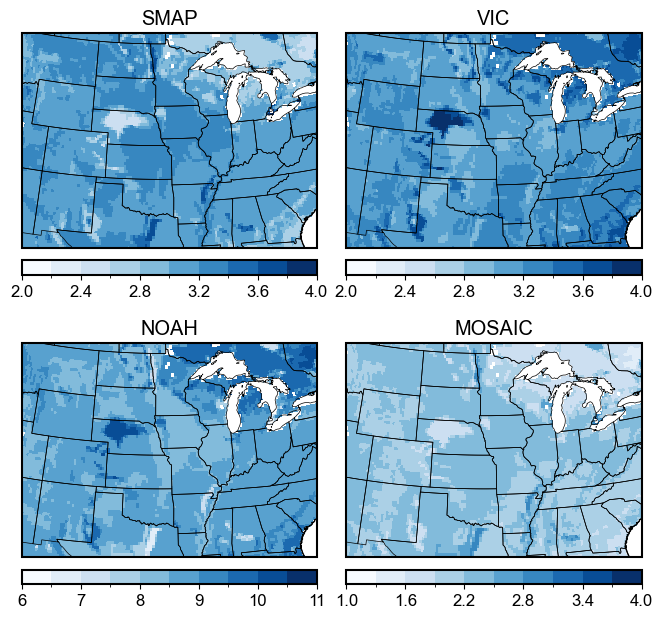

In [82]:
# Plot betaHBV
ds_soilfrac = xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/soilfrac_NLDASgrid.nc')

fig, axs = plt.subplots(2,2, figsize=(8,8),
                        subplot_kw=dict(projection=ccrs.LambertConformal()),
                        gridspec_kw=dict(wspace=0.1, hspace=0.01))
axs = axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get best param set
    iparam_best = df_res.sort_values(by=f'{obs}_rmse')['iparam'].iloc[0]
    # Calculate best betaHBV map
    betaHBV_sandcoef = df_params.iloc[iparam_best]['betaHBV_sandcoef']
    betaHBV_siltcoef = df_params.iloc[iparam_best]['betaHBV_siltcoef']
    betaHBV_claycoef = df_params.iloc[iparam_best]['betaHBV_claycoef']

    betaHBV = 1. + (betaHBV_sandcoef * ds_soilfrac['GLDAS_soilfraction_sand']) + \
    (betaHBV_siltcoef * ds_soilfrac['GLDAS_soilfraction_silt']) + \
    (betaHBV_claycoef * ds_soilfrac['GLDAS_soilfraction_clay'])
    # Plot
    p = betaHBV.plot(ax=axs[ido], vmin=np.round(betaHBV.min()-0.5), vmax=np.round(betaHBV.max()+0.5), cmap="Blues", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    # Tidy
    axs[ido].set_title(obs.upper())
    # cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label=None,
                 ax=axs[ido],
                 pad=0.04)

# Tidy
xlims = [-110, -80] # central US
ylims = [30,49] # central US
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
plt.show()

### OLD

In [5]:
print(f'Best SMAP correlation: {df_res.smap_pearsonr_anom.argmax()}')
ibest_corr_smap = df_res.smap_pearsonr_anom.argmax()

print(f'Best Noah correlation: {df_res.noah_pearsonr_anom.argmax()}')
ibest_corr_noah = df_res.noah_pearsonr_anom.argmax()

print(f'Best VIC correlation: {df_res.vic_pearsonr_anom.argmax()}')
ibest_corr_vic = df_res.vic_pearsonr_anom.argmax()

print(f'Best MOSAIC correlation: {df_res.mosaic_pearsonr_anom.argmax()}')
ibest_corr_mosaic = df_res.mosaic_pearsonr_anom.argmax()

print('\n')
print(f'Best SMAP rmse: {df_res.smap_rmse_anom.argmin()}')
ibest_mse_smap = df_res.smap_rmse_anom.argmin()

print(f'Best Noah rmse: {df_res.noah_rmse_anom.argmin()}')
ibest_mse_noah = df_res.noah_rmse_anom.argmin()

print(f'Best VIC rmse: {df_res.vic_rmse_anom.argmin()}')
ibest_mse_vic = df_res.vic_rmse_anom.argmin()

print(f'Best MOSAIC rmse: {df_res.mosaic_rmse_anom.argmin()}')

Best SMAP correlation: 5836
Best Noah correlation: 623
Best VIC correlation: 1252
Best MOSAIC correlation: 9120


Best SMAP rmse: 6248
Best Noah rmse: 8473
Best VIC rmse: 6876
Best MOSAIC rmse: 6248


In [6]:
print(f'Best SMAP correlation: {df_res_no_anom.smap_pearsonr.argmax()}')
ibest_corr_smap = df_res_no_anom.smap_pearsonr.argmax()

print(f'Best Noah correlation: {df_res_no_anom.noah_pearsonr.argmax()}')
ibest_corr_noah = df_res_no_anom.noah_pearsonr.argmax()

print(f'Best VIC correlation: {df_res_no_anom.vic_pearsonr.argmax()}')
ibest_corr_vic = df_res_no_anom.vic_pearsonr.argmax()

print(f'Best MOSAIC correlation: {df_res_no_anom.mosaic_pearsonr.argmax()}')
ibest_corr_mosaic = df_res_no_anom.mosaic_pearsonr.argmax()

print('\n')
print(f'Best SMAP rmse: {df_res_no_anom.smap_rmse.argmin()}')
ibest_mse_smap = df_res_no_anom.smap_rmse.argmin()

print(f'Best Noah rmse: {df_res_no_anom.noah_rmse.argmin()}')
ibest_mse_noah = df_res_no_anom.noah_rmse.argmin()

print(f'Best VIC rmse: {df_res_no_anom.vic_rmse.argmin()}')
ibest_mse_vic = df_res_no_anom.vic_rmse.argmin()

print(f'Best MOSAIC rmse: {df_res_no_anom.mosaic_rmse.argmin()}')
ibest_mse_mosaic = df_res_no_anom.mosaic_rmse.argmin()

Best SMAP correlation: 5836
Best Noah correlation: 623
Best VIC correlation: 3847
Best MOSAIC correlation: 9120


Best SMAP rmse: 1160
Best Noah rmse: 7788
Best VIC rmse: 4382
Best MOSAIC rmse: 2854


In [7]:
df_param = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_alpha_const.csv')

In [8]:
df_param.iloc[[ibest_corr_smap, ibest_corr_noah, ibest_corr_vic, ibest_corr_mosaic, ibest_mse_smap, ibest_mse_noah, ibest_mse_vic, ibest_mse_mosaic]]

,awCap_factor,wiltingp_factor,alpha,betaHBV_claycoef,betaHBV_sandcoef,betaHBV_siltcoef,iparam
5836,1.202403,2.165313,1.506576,3.241720,0.652308,1.830219,5836
623,0.814503,1.696787,0.117014,5.558609,1.684454,6.904248,623
3847,0.710404,2.023073,2.092385,2.640719,6.288485,0.120428,3847
9120,1.170509,0.645305,4.281420,2.014212,4.210005,0.239972,9120
1160,0.716463,2.891398,1.140389,3.306659,1.260779,2.542753,1160
7788,0.721972,1.999814,0.252058,3.696857,9.691212,7.472676,7788
4382,1.081675,1.253192,0.989837,1.666759,3.108815,1.238707,4382
2854,1.270375,1.036169,3.445449,2.998018,0.317583,1.242772,2854


In [9]:
df_res_no_anom.iloc[[ibest_corr_smap, ibest_corr_noah, ibest_corr_vic, ibest_corr_mosaic, ibest_mse_smap, ibest_mse_noah, ibest_mse_vic, ibest_mse_mosaic]]

,iparam,smap_pearsonr,vic_pearsonr,noah_pearsonr,mosaic_pearsonr,smap_rmse,vic_rmse,noah_rmse,mosaic_rmse
5836,5836,0.862177,0.872898,0.790791,0.874457,115.945020,97.026160,122.644040,117.158170
623,623,0.833201,0.890071,0.811647,0.824699,60.058970,37.952140,25.826506,32.323647
3847,3847,0.842703,0.898447,0.794420,0.847396,80.794610,63.084324,37.439636,41.441345
9120,9120,0.848613,0.856073,0.753451,0.882973,103.408380,83.087210,62.034172,60.551430
1160,1160,0.838217,0.895092,0.803687,0.835610,58.867348,36.536034,35.462566,38.925050
7788,7788,0.819735,0.888240,0.805561,0.809456,63.166077,41.821710,24.496700,32.560116
4382,4382,0.860453,0.883064,0.800672,0.866883,59.398514,35.841476,36.716950,33.066704
2854,2854,0.854444,0.861611,0.766394,0.879450,68.987686,49.415257,37.355743,29.111639


In [10]:
df_res_no_anom.min(axis=0)

iparam              0.000000
smap_pearsonr       0.419804
vic_pearsonr        0.388102
noah_pearsonr       0.386423
mosaic_pearsonr     0.476182
smap_rmse          58.867348
vic_rmse           35.841476
noah_rmse          24.496700
mosaic_rmse        29.111639
dtype: float64

In [12]:
# Read obs
smap_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc')
noah_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/NOAH_validation.nc')
vic_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/VIC_validation.nc')
mosaic_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/MOSAIC_validation.nc')

In [11]:
# RMSE
def _calculate_rmse(ds1, ds2):
    return np.sqrt((ds1 - ds2)**2).mean(dim='time')

In [74]:
_calculate_rmse(mosaic_obs['soilMoist'].isel(time=slice(100,3000)), noah_obs['soilMoist'].isel(time=slice(100,3000))).mean()

<xarray.DataArray 'soilMoist' ()>
array(36.933933, dtype=float32)

In [73]:
_calculate_rmse(noah_obs['soilMoist'].isel(time=slice(100,3000)), mosaic_obs['soilMoist'].isel(time=slice(100,3000))).mean()

<xarray.DataArray 'soilMoist' ()>
array(36.933933, dtype=float32)

In [69]:
_calculate_rmse(vic_obs['soilMoist'].isel(time=slice(100,3000)), mosaic_obs['soilMoist'].isel(time=slice(100,3000))).mean()

<xarray.DataArray 'soilMoist' ()>
array(42.44217, dtype=float32)

In [65]:
_calculate_rmse(smap_obs['soilMoist'].isel(time=slice(100,3000)), mosaic_obs['soilMoist'].isel(time=slice(100,3000))).mean()

<xarray.DataArray 'soilMoist' ()>
array(64.51022, dtype=float32)

In [50]:
df_res_no_anom.sort_values(by='noah_rmse')

,iparam,smap_pearsonr,vic_pearsonr,noah_pearsonr,mosaic_pearsonr,smap_rmse,vic_rmse,noah_rmse,mosaic_rmse
7788,7788,0.819735,0.888240,0.805561,0.809456,63.166077,41.821710,24.496700,32.560116
1239,1239,0.815054,0.888011,0.804062,0.804314,67.596310,48.154293,25.714113,34.266780
623,623,0.833201,0.890071,0.811647,0.824699,60.058970,37.952140,25.826506,32.323647
8473,8473,0.805446,0.882912,0.801040,0.793161,65.964930,47.701576,26.589410,36.254550
7476,7476,0.822282,0.891768,0.804382,0.814250,68.243645,49.958900,27.442675,35.175420
...,...,...,...,...,...,...,...,...,...
6293,6293,0.591370,0.520652,0.525745,0.648862,2367.619000,2376.098900,2404.027300,2399.444600
4426,4426,0.617454,0.548526,0.552269,0.677289,2383.221200,2391.671400,2419.569600,2415.027800
4935,4935,0.593423,0.528140,0.526470,0.655108,2407.810800,2416.322000,2444.191000,2439.678500
3418,3418,0.578182,0.510379,0.516126,0.638544,2420.211700,2428.737800,2456.640400,2452.083500


In [13]:
# Plot
def read_sim(iparam, smap_obs):
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}_Ws.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=smap_obs.lon,
                lat=smap_obs.lat,
                time=smap_obs.time))
    # Get anomaly from weekly climatology
    ds_sim = ds_sim.assign_coords(week=ds_sim.time.dt.strftime("%W"))
    ds_sim['soilMoist_anom'] = (ds_sim['soilMoist'].groupby('week') - ds_sim['soilMoist'].groupby("week").mean("time"))

    # Return
    return ds_sim

# Read other observations
smap_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc')
noah_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/NOAH_validation.nc')
vic_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/VIC_validation.nc')
mosaic_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/MOSAIC_validation.nc')

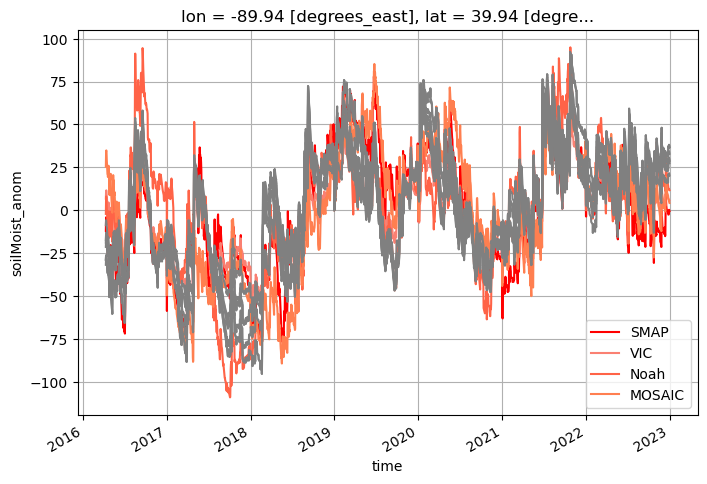

In [36]:
# Plot point
lat = 40
lon = -90

var_id = 'soilMoist_anom'

fig, ax = plt.subplots(figsize=(8,5))


# Obs
smap_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='SMAP', color='red')
vic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='VIC', color='salmon')
noah_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='Noah', color='tomato')
mosaic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='MOSAIC', color='coral')

# Sim
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

read_sim(ibest_mse_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

ax.legend()
ax.grid()

plt.show()

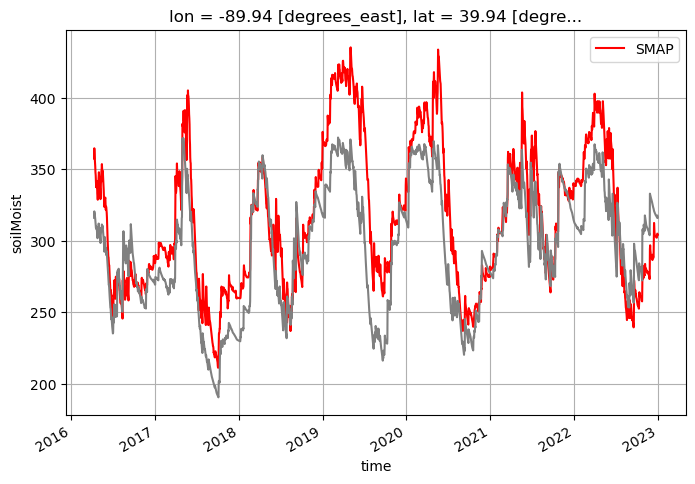

In [16]:
# Plot point
lat = 40
lon = -90

var_id = 'soilMoist'

fig, ax = plt.subplots(figsize=(8,5))


# Obs
smap_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='SMAP', color='red')
# read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

# vic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='VIC', color='salmon')
# read_sim(ibest_corr_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
# read_sim(ibest_mse_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

# noah_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='Noah', color='tomato')
# read_sim(ibest_corr_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
# read_sim(ibest_mse_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

# mosaic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='MOSAIC', color='coral')
# read_sim(ibest_corr_mosaic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
# read_sim(ibest_mse_mosaic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

ax.legend()
ax.grid()

plt.show()

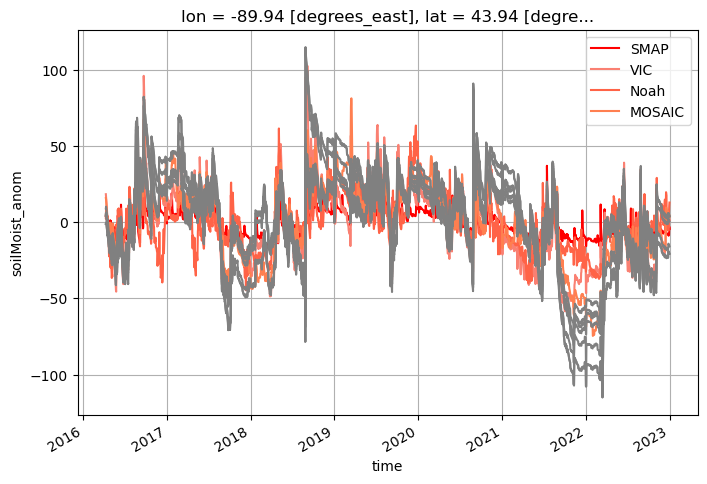

In [37]:
# Plot point
lat = 44
lon = -90

var_id = 'soilMoist_anom'

fig, ax = plt.subplots(figsize=(8,5))


# Obs
smap_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='SMAP', color='red')
vic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='VIC', color='salmon')
noah_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='Noah', color='tomato')
mosaic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='MOSAIC', color='coral')

# Sim
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

read_sim(ibest_mse_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

ax.legend()
ax.grid()

plt.show()

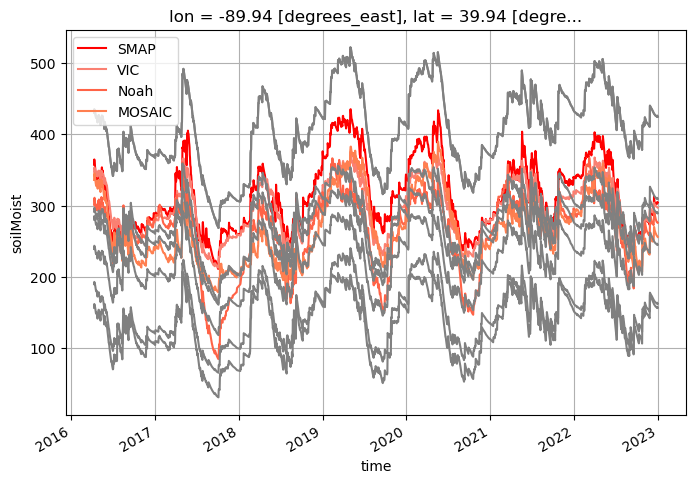

In [40]:
# Plot point
lat = 40
lon = -90

var_id = 'soilMoist'

fig, ax = plt.subplots(figsize=(8,5))


# Obs
smap_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='SMAP', color='red')
vic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='VIC', color='salmon')
noah_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='Noah', color='tomato')
mosaic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='MOSAIC', color='coral')

# Sim
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

read_sim(ibest_mse_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

ax.legend()
ax.grid()

plt.show()

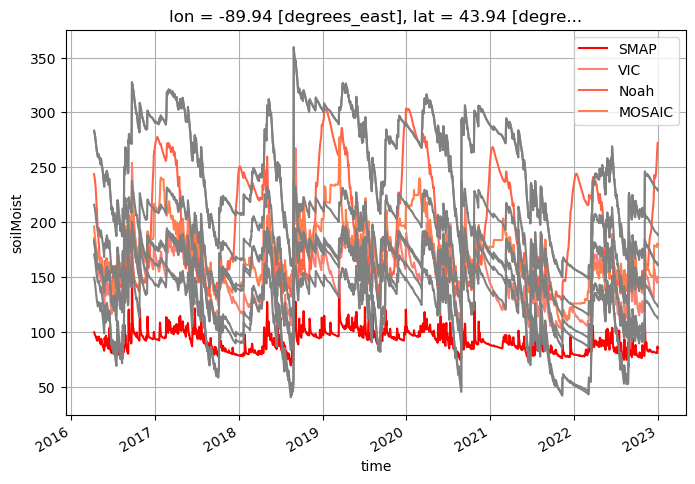

In [39]:
# Plot point
lat = 44
lon = -90

var_id = 'soilMoist'

fig, ax = plt.subplots(figsize=(8,5))


# Obs
smap_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='SMAP', color='red')
vic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='VIC', color='salmon')
noah_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='Noah', color='tomato')
mosaic_obs.sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label='MOSAIC', color='coral')

# Sim
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_corr_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

read_sim(ibest_mse_noah, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_smap, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')
read_sim(ibest_mse_vic, smap_obs).sel(lat=lat, lon=lon, method='nearest')[var_id].isel(time=slice(100,3000)).plot(ax=ax, label=None, color='gray')

ax.legend()
ax.grid()

plt.show()

In [20]:
# Single best parameter combo
i_best = np.argmin(mse_all_drop)

# Top N parameter combos
n_cutoff = 100
i_top = np.argpartition(mse_all_drop, n_cutoff)[:n_cutoff]

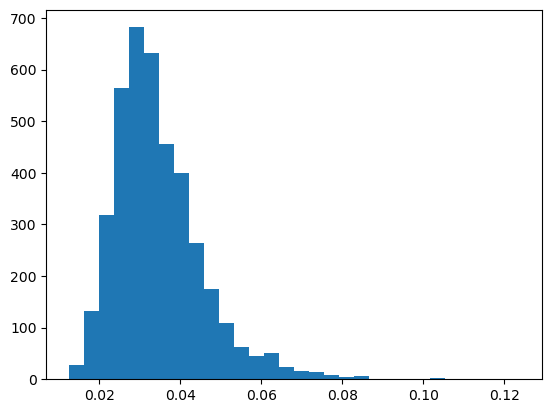

In [21]:
fig, ax = plt.subplots()
ax.hist(mse_all_drop, bins=30)
plt.show()

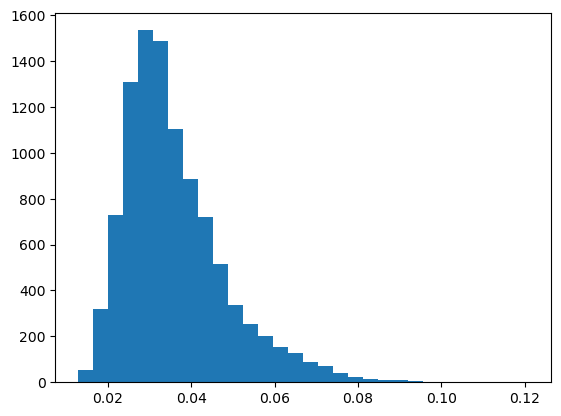

In [14]:
fig, ax = plt.subplots()
ax.hist(mse_all, bins=30)
plt.show()

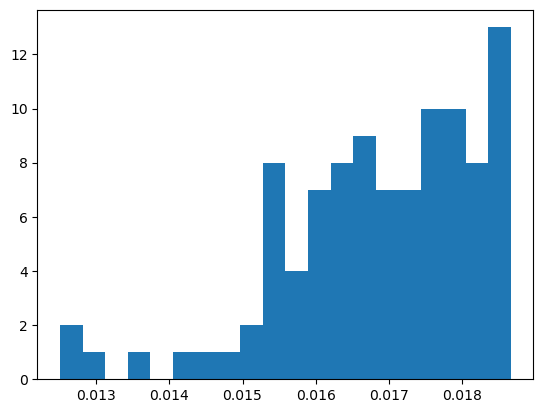

In [22]:
fig, ax = plt.subplots()
ax.hist(np.take(mse_all_drop, i_top), bins=20)
plt.show()

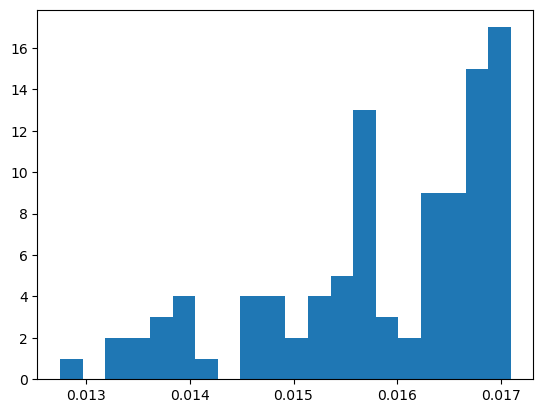

In [13]:
fig, ax = plt.subplots()
ax.hist(np.take(mse_all, i_top), bins=20)
plt.show()

In [15]:
####################### 5000

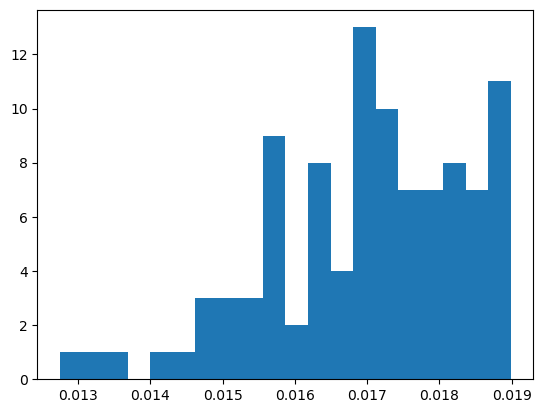

In [20]:
fig, ax = plt.subplots()
ax.hist(np.take(mse_all, i_top), bins=20)
plt.show()

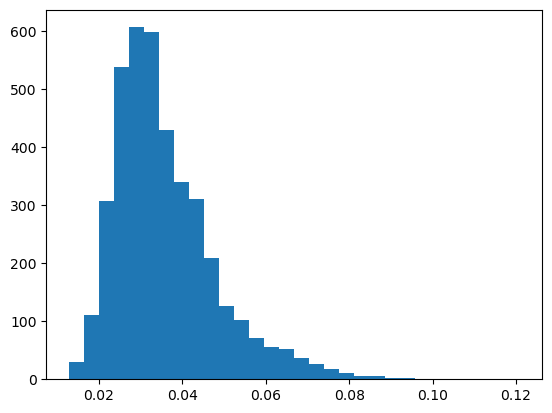

In [16]:
fig, ax = plt.subplots()
ax.hist(mse_all, bins=30)
plt.show()

In [24]:
df_param = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params.csv')
df_param[df_param.iparam == i_best]

,awCap_factor,wiltingp_factor,alpha_claycoef,alpha_sandcoef,alpha_siltcoef,betaHBV_claycoef,betaHBV_sandcoef,betaHBV_siltcoef,iparam
3638,1.278421,3.117335,5.789309,9.346146,3.214103,0.687924,0.024272,2.523833,3638


In [20]:
df_param = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params.csv')
df_param[df_param.iparam == i_best]

,awCap_factor,wiltingp_factor,alpha_claycoef,alpha_sandcoef,alpha_siltcoef,betaHBV_claycoef,betaHBV_sandcoef,betaHBV_siltcoef,iparam
3638,1.278421,3.117335,5.789309,9.346146,3.214103,0.687924,0.024272,2.523833,3638


<Axes: ylabel='Frequency'>

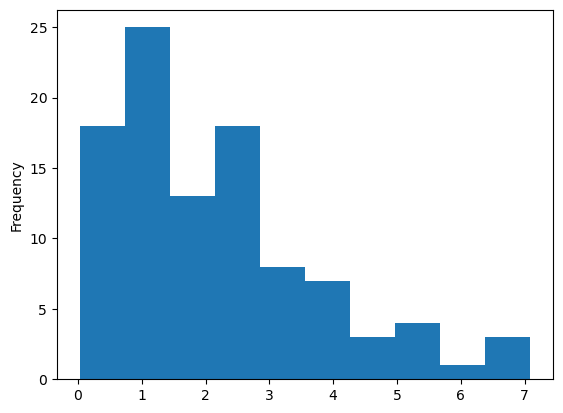

In [32]:
df_param[df_param.iparam.isin(i_top)]['betaHBV_siltcoef'].plot(kind='hist')

<Axes: ylabel='Frequency'>

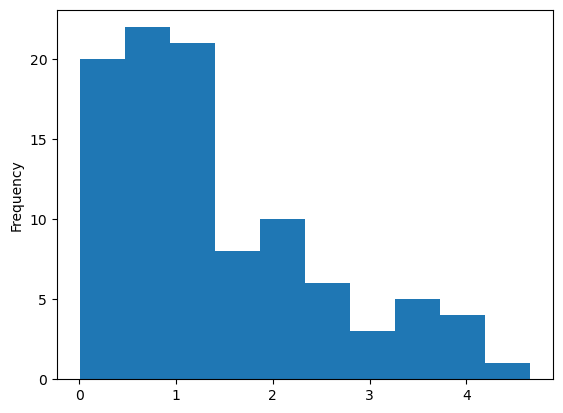

In [17]:
df_param[df_param.iparam.isin(i_top)]['betaHBV_siltcoef'].plot(kind='hist')

In [23]:
# Read obs and best
smap_obs = np.load(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs.npy')
best_sim = np.load(f'{store_path}/{str(i_best)}_alphaC.npy')

In [31]:
tmp_sim_alpha = np.load(f'{store_path}/{str(i_best)}_alphaC.npy')
tmp_sim = np.load(f'{store_path}/{str(i_best)}.npy')

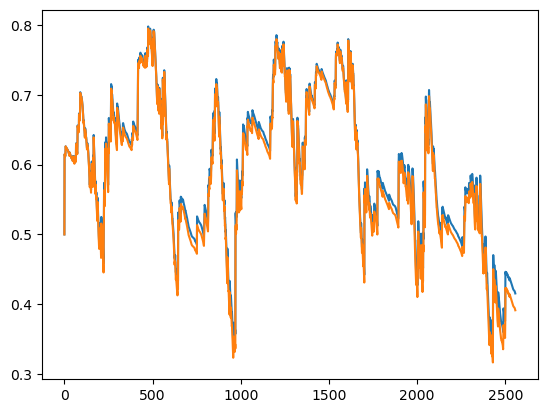

In [32]:
plt.plot(tmp_sim_alpha[106,66,:])
plt.plot(tmp_sim[106,66,:])

NameError: name 'best_sim' is not defined

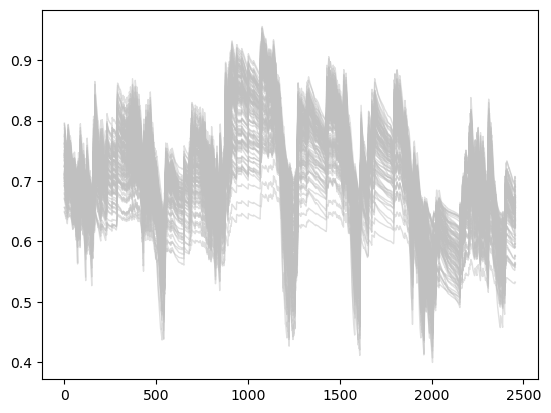

In [18]:
fig, ax = plt.subplots()

ix,iy=100,50

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}_alphaC.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

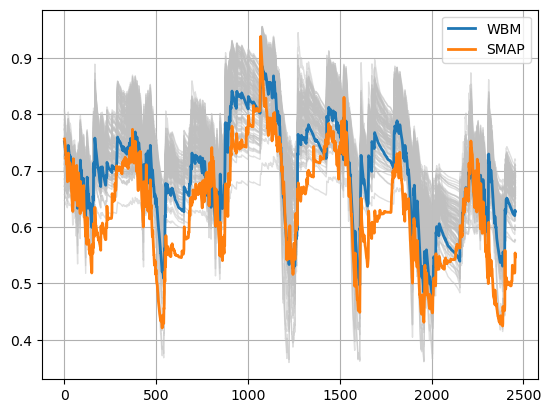

In [22]:
fig, ax = plt.subplots()

ix,iy=100,50

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

In [23]:
np.nanmax(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))))

/tmp/ipykernel_1101456/838063472.py:1: RuntimeWarning: Mean of empty slice
  np.nanmax(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))))


0.21198724

In [42]:
mse_spatial = np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2)
np.unravel_index(np.nanargmin(mse_spatial, axis=None), mse_spatial.shape)

/tmp/ipykernel_1101456/2300403976.py:1: RuntimeWarning: Mean of empty slice
  mse_spatial = np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2)


(87, 56)

In [71]:
ix,iy=106,66
np.nanmean((best_sim[ix,iy,100:] - smap_obs[ix,iy,100:])**2)

0.16763018

/tmp/ipykernel_1101456/1179283558.py:3: RuntimeWarning: Mean of empty slice
  img = ax.imshow(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))),


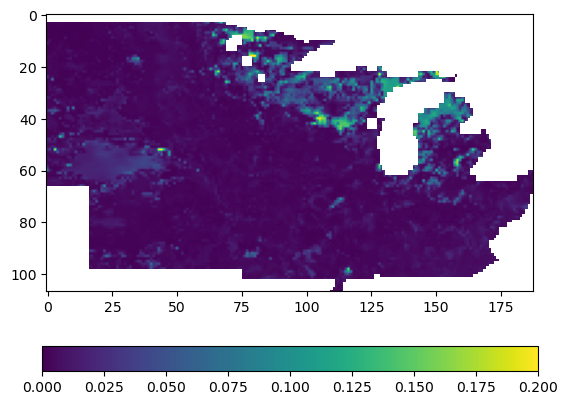

In [56]:
fig, ax = plt.subplots()

img = ax.imshow(np.flipud(np.transpose(np.nanmean((best_sim[:,:,100:] - smap_obs[:,:,100:])**2, axis=2))),
               vmin=0., vmax=0.2)

fig.colorbar(img, ax=ax, orientation='horizontal', fraction=.1)

plt.show()

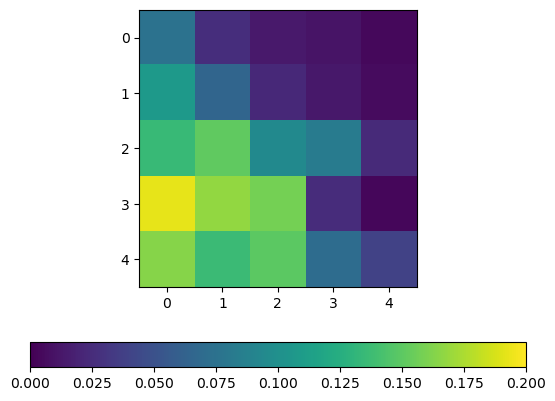

In [68]:
fig, ax = plt.subplots()

img = ax.imshow(np.flipud(np.transpose(np.nanmean((best_sim[105:110,65:70,100:] - smap_obs[105:110,65:70,100:])**2, axis=2))),
               vmin=0., vmax=0.2)

fig.colorbar(img, ax=ax, orientation='horizontal', fraction=.1)

plt.show()

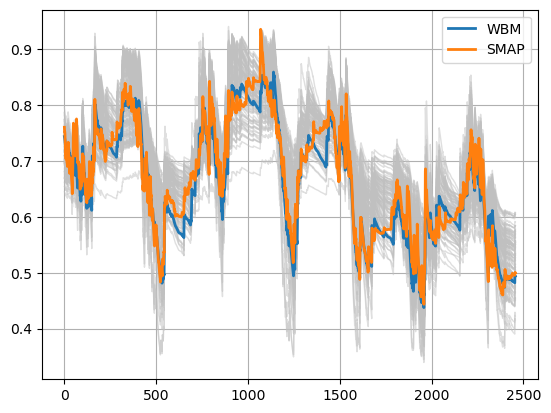

In [43]:
fig, ax = plt.subplots()

ix,iy=87,56

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

In [46]:
npz = np.load(f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz')

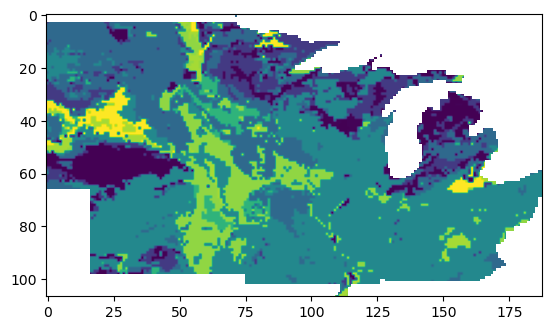

In [54]:
plt.imshow(np.flipud(np.transpose(npz['wiltingp'])))

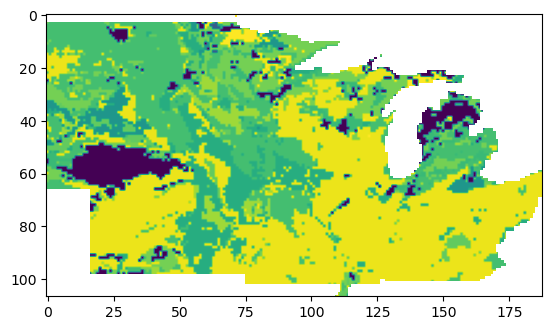

In [53]:
plt.imshow(np.flipud(np.transpose(npz['awCap'])))

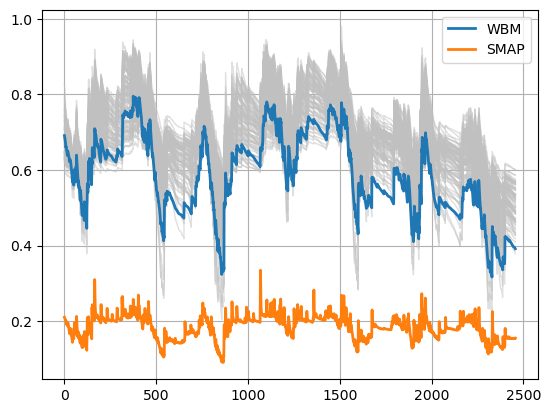

In [72]:
fig, ax = plt.subplots()

ix,iy=106,66

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()

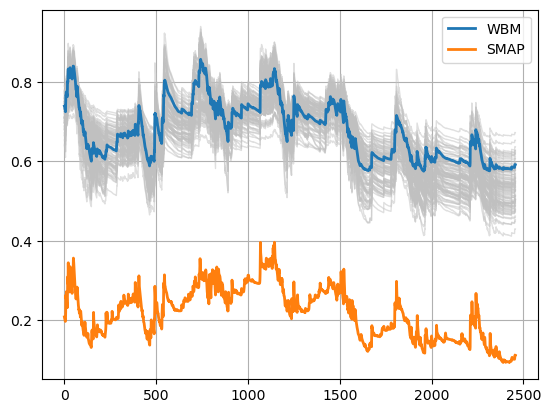

In [38]:
fig, ax = plt.subplots()

ix,iy=44,54

for iparam in i_top:
    # Load
    tmp_sim = np.load(f'{store_path}/{str(iparam)}.npy')
    # Plot
    ax.plot(tmp_sim[ix,iy,100:], lw=1, color='silver', alpha=0.5, label=None)

ax.plot(best_sim[ix,iy,100:], label='WBM', lw=2)
ax.plot(smap_obs[ix,iy,100:], label='SMAP', lw=2)

ax.grid()
ax.legend()

plt.show()